### Libraries

In [1]:
import pandas as pd
import gzip
from io import BytesIO
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from datetime import datetime

import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import gaussian_kde
import statsmodels.api as sm


pd.options.mode.chained_assignment = None

### Helper Functions

In [2]:
#function to convert data and time formats and create a column that contain both values in datetime format
def converti_data_ora(row):
    data_str = str(row['Data'])
    ora_str = str(row['Ora'])  # -1 because the range time is from 0 to 23 so ex. hour 1 corresponds to 00:00
    data_ora_str = data_str[:4] + '-' + data_str[4:6] + '-' + data_str[6:] + ' ' + ora_str + ':00:00'
    return datetime.strptime(data_ora_str, '%Y-%m-%d %H:%M:%S')


# Polynomial smoothing
def smooth_series(series, degree=2):
    y = series.values
    mask = ~np.isnan(y)
    coefs = Polynomial.fit(x[mask], y[mask], deg=degree)
    return coefs(x)

# LOESS smoothing 
def apply_loess(series, frac=0.3):
    lowess = sm.nonparametric.lowess # LOESS smoothing
    smoothed_values = lowess(series, series.index, frac=frac, return_sorted=False) # The series index is numeric and represents hours
    return smoothed_values

#### Reading the Data in

In [3]:
path = ''
file = './ts_df.pkl.gz'
with gzip.open(path+file, 'rb') as f:
    loaded_df = pd.read_pickle(f)


In [23]:
# from tqdm.notebook import tqdm
# import os
# from os.path import join

# market = 'MGP'
# dataset = 'DomandaOfferta'
# date_range = pd.date_range(start='2023-01-01', end='2023-12-31')

# df_list = []

# for date in tqdm(date_range):   #iterate in the range specified before 
    
#     date = date.strftime('%Y%m%d') #ex. 2019-01-01 --> 20190101
#     file_path = join('data', market +'_'+ dataset, str(date) + market + dataset + '.xml') #file path = data/MGP_DomandaOfferta/20190101DomandaOfferta
    
#     if not(os.path.exists(file_path)):      #check correct path existance
#         print(f"{file_path} not found")
#     else:
#         df = pd.read_xml(file_path, xpath=f'./{dataset}')  #read xml file and w in df 
#     df_list.append(df)

# loaded_df = pd.concat(df_list, ignore_index=True)  #create a unique dataframe 
# loaded_df

  0%|          | 0/365 [00:00<?, ?it/s]

data/MGP_DomandaOfferta/20230101MGPDomandaOfferta.xml not found


NameError: name 'df' is not defined

### Filter df

In [4]:
# Getting 2023 Values

loaded_df['Data'] = pd.to_datetime(loaded_df['Data'], format='%Y%m%d')
loaded_df = loaded_df.loc[loaded_df['Data'].dt.year == 2023,:]

In [5]:
loaded_df = loaded_df.loc[loaded_df.ZonaMercato=='CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CORS;FRAN;GREC;SLOV;SVIZ;MALT;COUP;MONT;',:]


In [6]:
# Combine 'Data' and 'Ora' columns and convert to datetime

loaded_df['Data'] = pd.to_datetime(loaded_df['Data'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
loaded_df['Ora'] = (loaded_df['Ora'] - 1).astype('Int64').astype(str).str.zfill(2) + ':00:00'
loaded_df['DataOra'] = pd.to_datetime(loaded_df['Data'] + ' ' + loaded_df['Ora'])

In [7]:
loaded_df['Ora']

1          00:00:00
2          00:00:00
3          00:00:00
4          00:00:00
5          00:00:00
             ...   
2965859    23:00:00
2965860    23:00:00
2965861    23:00:00
2965862    23:00:00
2965863    23:00:00
Name: Ora, Length: 1766386, dtype: object

In [8]:
# rename columns to English

column_mapping = {'Data': 'Day', 'Ora': 'Hour',"Mercato":"Market", 'ZonaMercato': 'MarketArea', 'PrezzoZonale': 'ZonalPrice', 'Quantita': 'Quantity', 'Prezzo': 'Price', 'Tipo': 'Type', "DataOra": "Date"}

loaded_df.rename(columns=column_mapping, inplace=True)

In [9]:
loaded_df

,id,element,Day,Hour,Market,MarketArea,ZonalPrice,Quantity,Price,Type,Date
1,None,None,2023-01-01,00:00:00,MGP,CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...,195.90,70000.000,4000.00,OFF,2023-01-01 00:00:00
2,None,None,2023-01-01,00:00:00,MGP,CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...,195.90,0.102,3000.00,OFF,2023-01-01 00:00:00
3,None,None,2023-01-01,00:00:00,MGP,CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...,195.90,20.001,800.00,OFF,2023-01-01 00:00:00
4,None,None,2023-01-01,00:00:00,MGP,CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...,195.90,7.530,700.00,OFF,2023-01-01 00:00:00
5,None,None,2023-01-01,00:00:00,MGP,CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...,195.90,0.003,632.00,OFF,2023-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2965859,None,None,2023-12-31,23:00:00,MGP,CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...,106.12,0.007,0.00,BID,2023-12-31 23:00:00
2965860,None,None,2023-12-31,23:00:00,MGP,CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...,106.12,50.000,-0.27,BID,2023-12-31 23:00:00
2965861,None,None,2023-12-31,23:00:00,MGP,CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...,106.12,9.000,-3.01,BID,2023-12-31 23:00:00
2965862,None,None,2023-12-31,23:00:00,MGP,CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CO...,106.12,54.000,-100.00,BID,2023-12-31 23:00:00


### Preprocess

In [10]:
#loaded_df[['ZonalPrice', 'MarketArea']].drop_duplicates()
columns_wanted = ['Date', 'ZonalPrice', 'Quantity','Price']

In [11]:
bid = loaded_df.loc[loaded_df.Type == "BID",columns_wanted]

bid_df = bid.copy()
bid.Price = bid.Price *-1 ## for bid prices, take the negative of it
bid = bid.sort_values(by=['Price']).reset_index(drop = True) # sort in ascending way
bid['Cumulative Quantity'] = bid.Quantity.cumsum()

ask = loaded_df.loc[loaded_df.Type == "OFF",columns_wanted]
ask_df = ask.copy()
ask = ask.sort_values(by=['Price']).reset_index(drop = True)
ask['Cumulative Quantity'] = ask.Quantity.cumsum()


## PLOTTIN FOR INITIAL OVERVIEW

#### BID

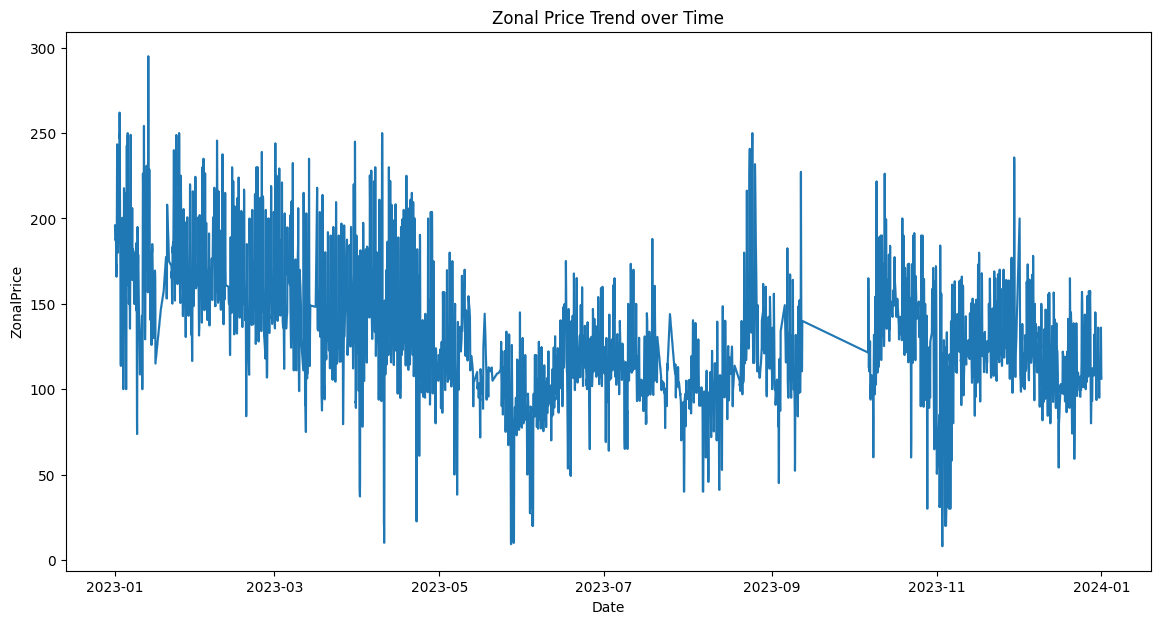

In [12]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='ZonalPrice', data=bid_df)
plt.title('Zonal Price Trend over Time')
plt.show()

In [13]:
# Extract hours and days of the week
bid_df['hour'] = bid_df['Date'].dt.hour
bid_df['day_week'] = bid_df['Date'].dt.dayofweek


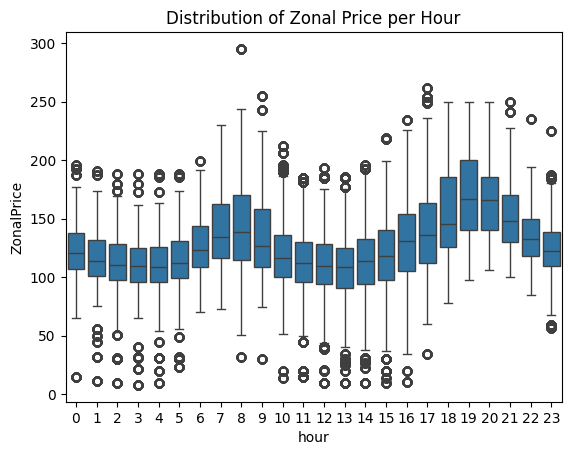

In [14]:
# Analysis for hours
sns.boxplot(x='hour', y='ZonalPrice', data=bid_df)
plt.title('Distribution of Zonal Price per Hour')
plt.show()

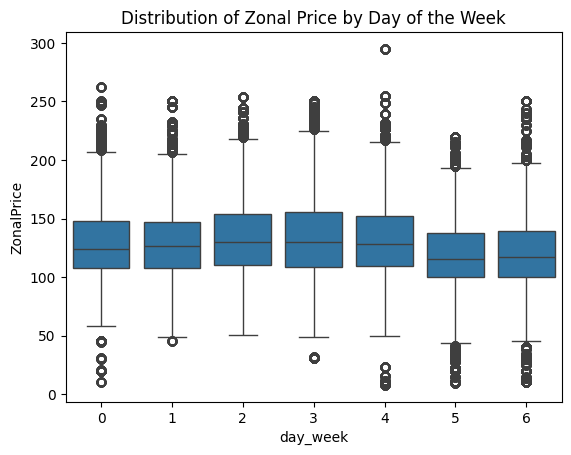

In [15]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='ZonalPrice', data=bid_df)
plt.title('Distribution of Zonal Price by Day of the Week')
plt.show()

#### ASK

In [16]:
# Extract hours and days of the week
ask_df['hour'] = ask_df['Date'].dt.hour
ask_df['day_week'] = ask_df['Date'].dt.dayofweek


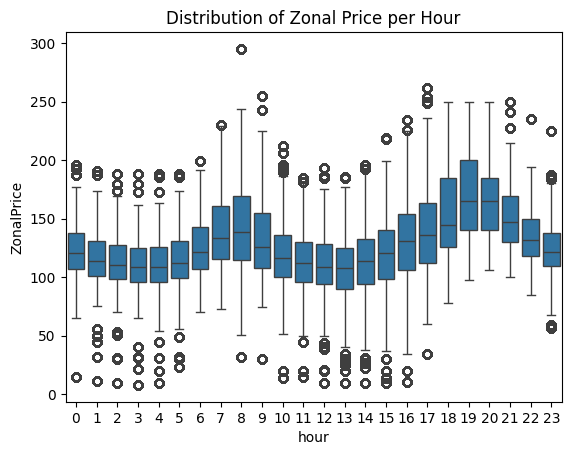

In [51]:
# Analysis for hours
sns.boxplot(x='hour', y='ZonalPrice', data=ask_df)
plt.title('Distribution of Zonal Price per Hour')
plt.show()

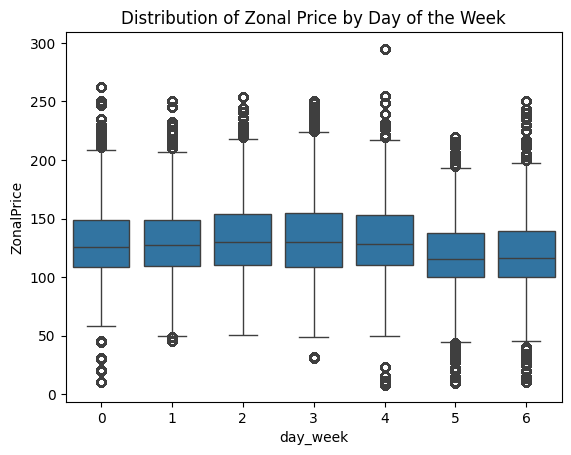

In [52]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='ZonalPrice', data=ask_df)
plt.title('Distribution of Zonal Price by Day of the Week')
plt.show()

## BID:  AGGREGATING AND TAKING MEAN

In [18]:
bid_df.set_index('Date', inplace=True)
zonal_price_means = bid_df.groupby(by=[bid_df.index]).agg({'ZonalPrice': 'mean'}).rename(columns={'ZonalPrice': 'MeanZonalPrice'}).reset_index()

In [19]:
# Extract hours and days of the week
zonal_price_means['hour'] = zonal_price_means['Date'].dt.hour
zonal_price_means['day_week'] = zonal_price_means['Date'].dt.dayofweek

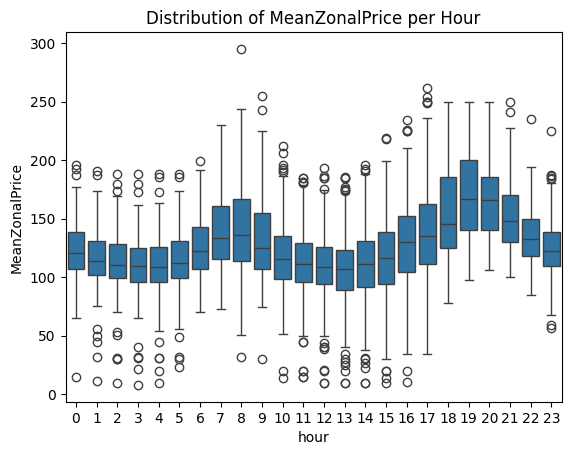

In [20]:
# Analysis for hours
sns.boxplot(x='hour', y='MeanZonalPrice', data=zonal_price_means)
plt.title('Distribution of MeanZonalPrice per Hour')
plt.show()

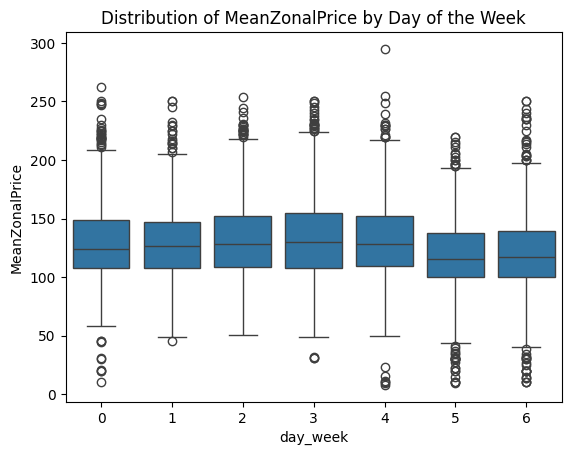

In [21]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='MeanZonalPrice', data=zonal_price_means)
plt.title('Distribution of MeanZonalPrice by Day of the Week')
plt.show()

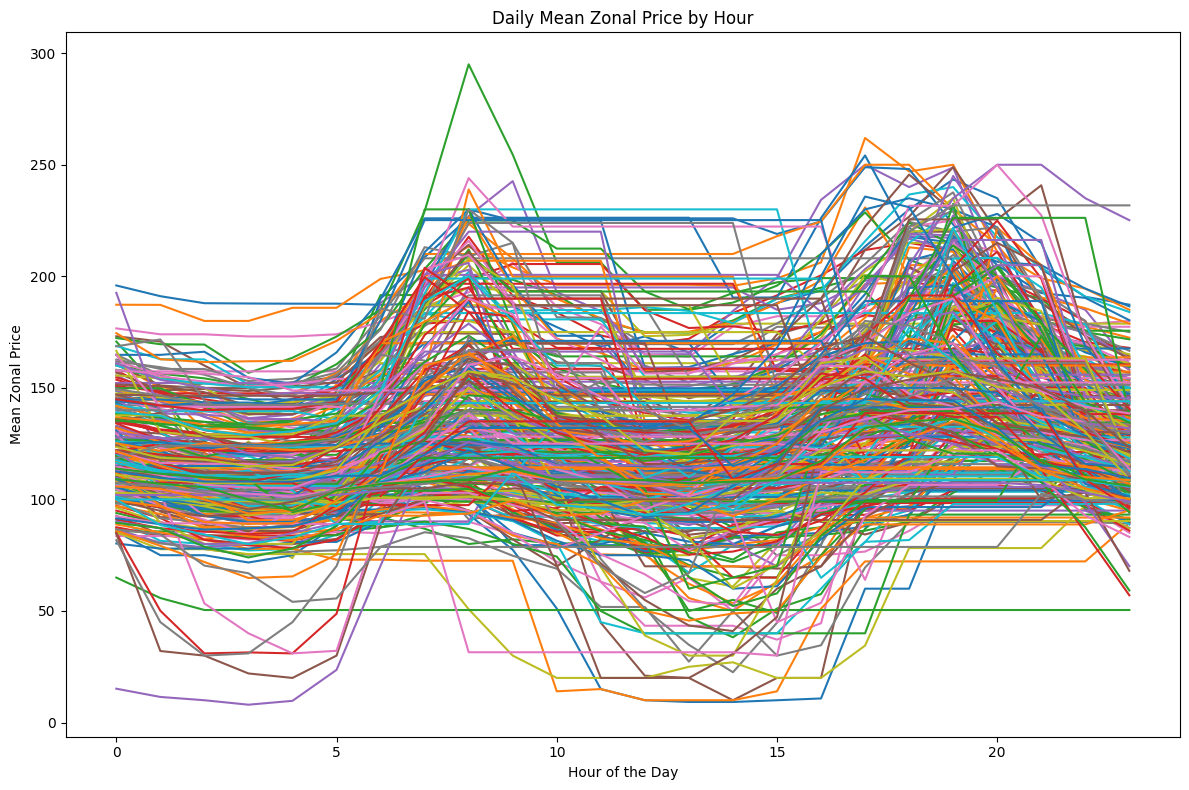

In [25]:
# Extract day from 'Date' to use it as a part of pivot
zonal_price_means['Day'] = zonal_price_means['Date'].dt.date

# Pivot the DataFrame to get days as columns and hours as rows
pivot_df = zonal_price_means.pivot(index='hour', columns='Day', values='MeanZonalPrice')
#pivot_df.ffill(axis=1, inplace=True) #### I AM FILLING MY DATA IN based on previous day's same hour value

pivot_df.ffill(axis=0, inplace=True) #### I AM FILLING MY DATA IN based on previous day's same hour value

# Plotting
plt.figure(figsize=(12, 8))

for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

plt.title('Daily Mean Zonal Price by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Zonal Price')
#plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

## SMOOTHEN

In [23]:
x = np.arange(24)  # Hours

POLYNOMIAL

In [24]:
# Smoothing to each day's data
smoothed_data = pivot_df.apply(smooth_series, axis=0)

# Plotting
plt.figure(figsize=(12, 8))

for column in smoothed_data.columns:
    plt.plot(smoothed_data.index, smoothed_data[column], label=column)

plt.title('Daily Mean Zonal Price by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Zonal Price')
#plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout
plt.tight_layout()

plt.show()

/home/mattia/.local/lib/python3.10/site-packages/numpy/polynomial/polyutils.py:303: RuntimeWarning: divide by zero encountered in scalar divide
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/home/mattia/.local/lib/python3.10/site-packages/numpy/polynomial/polyutils.py:304: RuntimeWarning: divide by zero encountered in scalar divide
  scl = newlen/oldlen
/home/mattia/.local/lib/python3.10/site-packages/numpy/polynomial/polyutils.py:372: RuntimeWarning: invalid value encountered in add
  return off + scl*x


 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

LOESS

/home/mattia/.local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


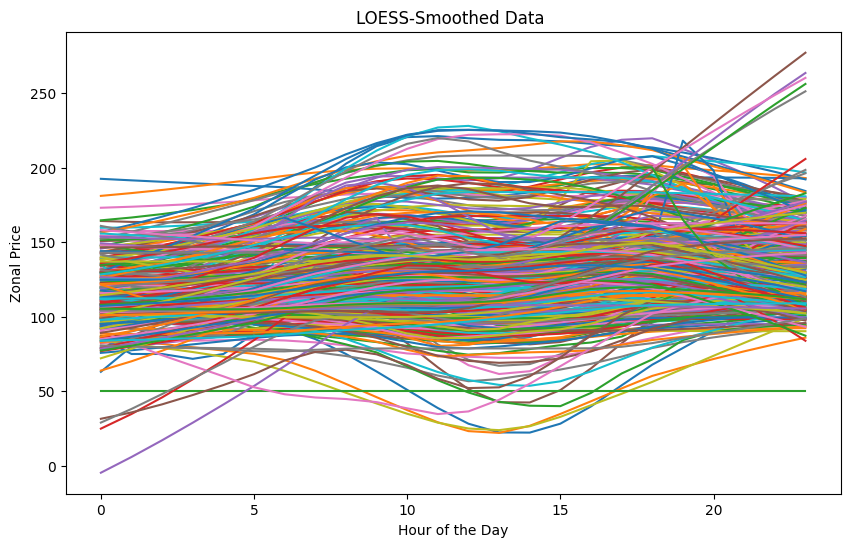

In [26]:
smoothed_df = pivot_df.apply(apply_loess, frac=0.5)  # Adjust frac as needed

# PLOT
plt.figure(figsize=(10, 6))
plt.plot(smoothed_df.index, smoothed_df, label='Smoothed with LOESS')
plt.title(f"LOESS-Smoothed Data ")
plt.xlabel('Hour of the Day')
plt.ylabel('Zonal Price')
plt.show()

In [64]:
smoothed_df

Day,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
hour,,,,,,,,,,,,,,,,,,,,,
0,192.437194,180.896343,118.895698,102.772427,104.234764,164.165301,172.354521,153.626187,133.547841,132.539834,...,76.112948,80.742317,102.216225,102.971240,104.108592,100.920130,80.598277,108.814634,100.969821,105.485163
1,191.418142,182.809908,126.170557,111.505435,112.779011,163.547151,173.351102,154.440273,134.462032,133.383115,...,79.549790,82.619516,102.178739,103.417342,104.021407,105.317190,85.162727,109.222595,101.336315,105.191998
2,190.449348,184.949477,134.160830,120.758476,122.429959,163.299527,174.510247,155.492466,136.230810,135.146773,...,83.529570,84.866512,102.262784,103.970560,104.054695,110.087140,90.284867,109.734636,101.874006,105.050702
3,189.499595,187.239818,142.488291,130.343474,132.826848,163.309057,175.819120,156.689348,138.533966,137.493345,...,87.956633,87.324869,102.410639,104.607326,104.174118,115.150988,95.770481,110.320725,102.518922,105.027747
4,188.552725,189.598500,150.714558,140.135074,143.588925,163.391204,177.263529,157.945812,140.982417,139.990420,...,92.698972,89.831284,102.548848,105.292390,104.326189,120.382010,101.368659,110.952974,103.169814,105.048176
5,187.657163,192.041050,158.583511,150.301090,154.836589,163.402021,178.900948,159.312220,142.509019,141.556052,...,97.782482,92.421051,102.668036,106.003179,104.478193,125.686202,106.997606,111.657836,103.729139,105.008306
6,186.743693,194.708925,167.633556,160.399683,168.987908,164.259841,180.973107,161.420272,147.703950,147.004109,...,105.537800,97.062459,103.178966,107.060846,105.229133,131.541509,110.714938,111.523758,105.095311,105.795793
7,185.348282,196.475501,176.975479,168.777626,181.228712,164.726111,182.156843,163.081687,155.414500,154.983481,...,112.325327,102.375677,103.700353,108.023525,106.122998,136.463534,113.121296,110.410039,106.678450,106.905342
8,183.400449,196.427930,183.969194,175.158618,189.882886,164.190734,182.444176,163.896352,162.615666,162.612991,...,117.239369,106.783127,104.171833,108.768602,106.926053,139.893917,114.565184,108.668646,107.950310,108.051840


## FPCA

In [61]:
import skfda
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,

)

ImportError: cannot import name 'TensorProductBasis' from 'skfda.representation.basis' (/Users/luca.distefano/opt/anaconda3/envs/appliedstatistics/lib/python3.12/site-packages/skfda/representation/basis/__init__.py)

In [42]:
from skfda.representation.grid import FDataGrid

data_array_transposed = smoothed_df.T.values
fd = FDataGrid(data_matrix=data_array_transposed)
fd

FDataGrid(
    array([[[192.43719377],
            [191.4181421 ],
            [190.44934754],
            ...,
            [193.24148474],
            [193.08348923],
            [192.75313516]],
    
           [[180.89634256],
            [182.80990818],
            [184.94947661],
            ...,
            [196.87559486],
            [195.09886111],
            [193.02526492]],
    
           [[118.89569821],
            [126.17055691],
            [134.16083016],
            ...,
            [181.00682657],
            [176.11738088],
            [170.74724802]],
    
           ...,
    
           [[108.81463409],
            [109.2225945 ],
            [109.73463582],
            ...,
            [121.73063702],
            [117.90111811],
            [113.63987979]],
    
           [[100.96982125],
            [101.33631516],
            [101.87400618],
            ...,
            [114.38503917],
            [113.23494524],
            [111.81756337]],
    
           [[

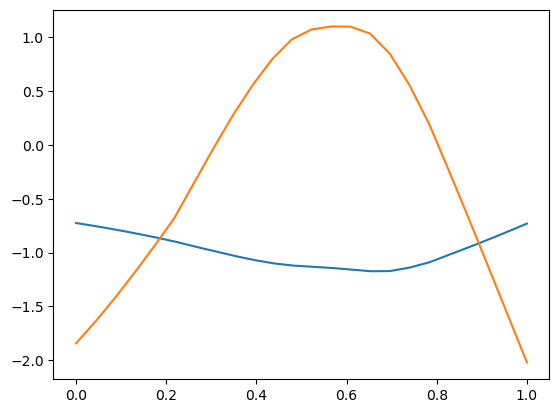

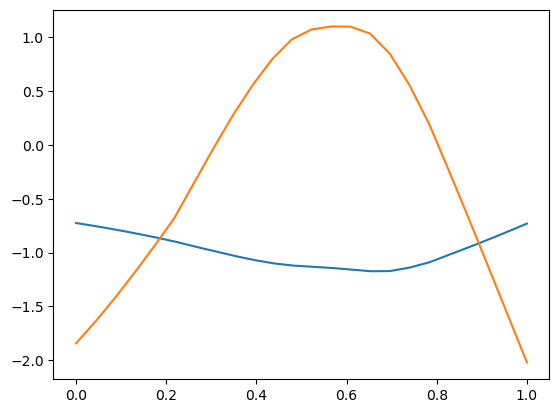

In [43]:

fpca = FPCA(n_components=2, components_basis=FourierBasis(n_basis=7))
fpca.fit(fd)
fpca.components_.plot()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


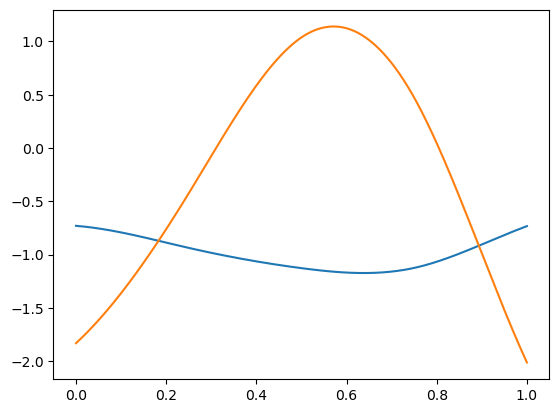

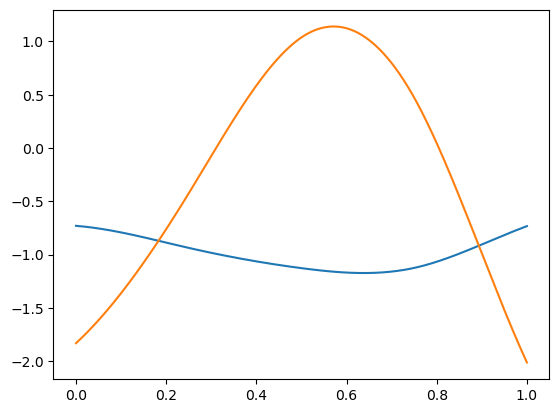

In [59]:
basis_fd = fd.to_basis(BSplineBasis(n_basis=7))
fpca = FPCA(n_components=2)
fpca.fit(basis_fd)
fpca.components_.plot()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


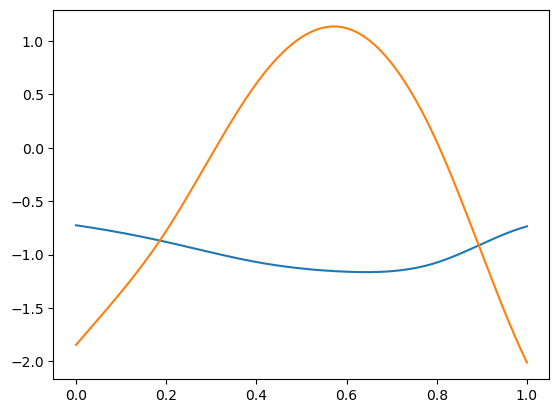

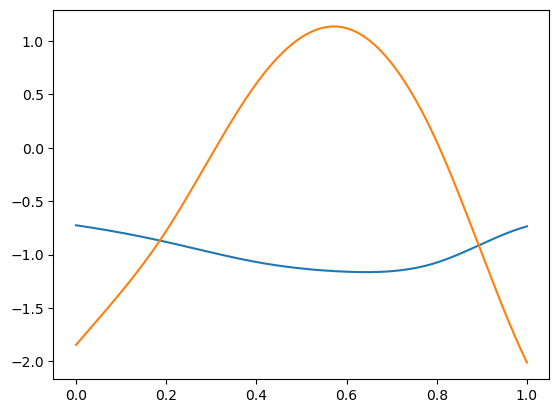

In [58]:
basis_fd = fd.to_basis(BSplineBasis(n_basis=8, order=4))
fpca = FPCA(n_components=2)
fpca.fit(basis_fd)
fpca.components_.plot()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


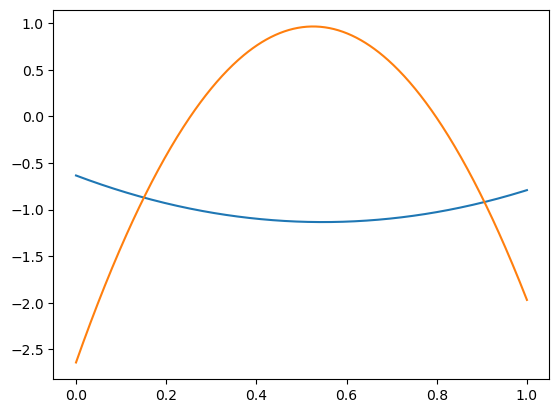

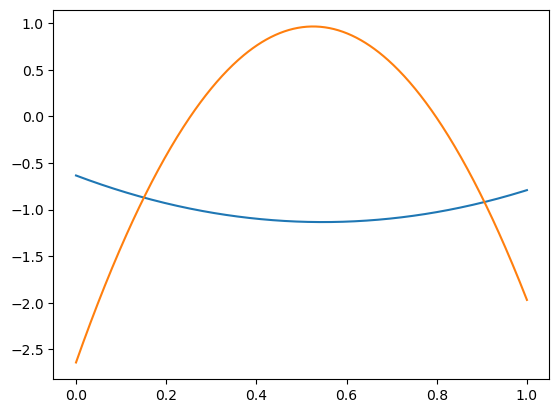

In [65]:
basis_fd = fd.to_basis(MonomialBasis(n_basis=3))
fpca = FPCA(n_components=2)
fpca.fit(basis_fd)
fpca.components_.plot()

### plots

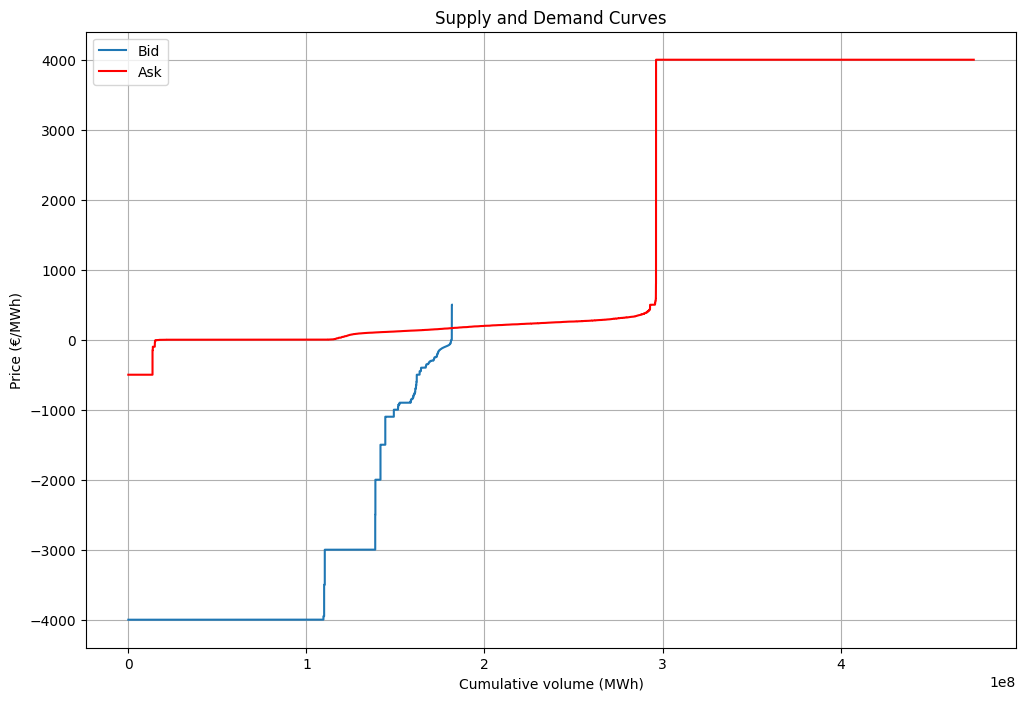

In [317]:
plt.figure(figsize=(12, 8))

plt.step(bid['Cumulative Quantity'], bid['Price'], label='Bid', where='post')
plt.step(ask['Cumulative Quantity'], ask['Price'], label='Ask', color='r', where='post')

plt.title('Supply and Demand Curves')
plt.xlabel('Cumulative volume (MWh)')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)

plt.show()

## Smoothening

In [366]:
MAX = 2
alpha = 0.8 

ask = ask.sort_values(by=['Day', 'Hour']).reset_index(drop = True)
ask['Price_Smoothed_Forward'] = ask['Price'].rolling(window=MAX).mean() # by working days
ask['Price_Smoothed_Centered'] = ask['Price'].rolling(window=MAX, center=True).mean() 
ask['Price_Smoothed_EWMA'] = ask['Price'].ewm(alpha=alpha).mean()



bid = bid.sort_values(by=['Day', 'Hour']).reset_index(drop = True)
bid['Price_Smoothed_Forward'] = bid['Price'].rolling(window=MAX).mean() # by working days
bid['Price_Smoothed_Centered'] = bid['Price'].rolling(window=MAX, center=True).mean()
bid['Price_Smoothed_EWMA'] = bid['Price'].ewm(alpha=alpha).mean()



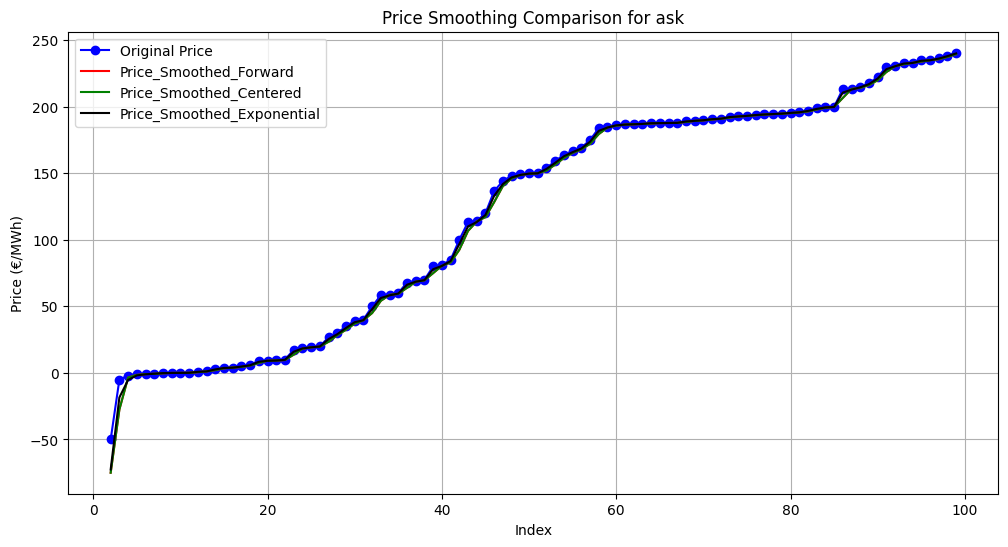

In [369]:
subset = ask.iloc[MAX:100]

plt.figure(figsize=(12, 6))

# Plot original prices
plt.plot(subset.index, subset['Price'], label='Original Price', color='blue', marker='o', linestyle='-')

# plot smooethened prices
plt.plot(subset.index, subset['Price_Smoothed_Forward'], label='Price_Smoothed_Forward', color='red', marker='', linestyle='-')
plt.plot(subset.index, subset['Price_Smoothed_Centered'], label='Price_Smoothed_Centered', color='green', marker='', linestyle='-')
plt.plot(subset.index, subset['Price_Smoothed_EWMA'], label='Price_Smoothed_Exponential', color='black', marker='', linestyle='-')


plt.title('Price Smoothing Comparison for ask')
plt.xlabel('Index')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

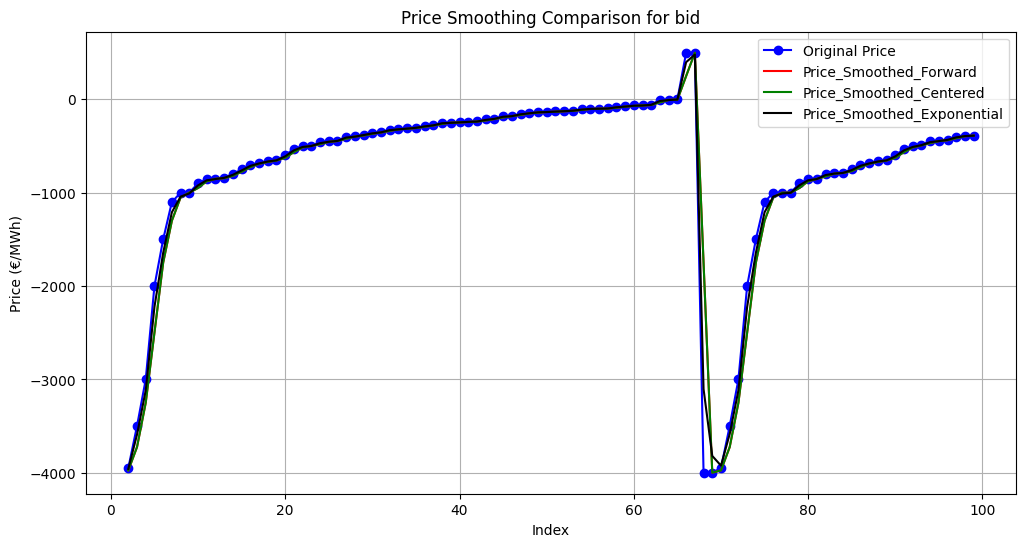

In [370]:
subset = bid.iloc[MAX:100]

plt.figure(figsize=(12, 6))

# Plot original prices
plt.plot(subset.index, subset['Price'], label='Original Price', color='blue', marker='o', linestyle='-')

# plot smooethened prices
plt.plot(subset.index, subset['Price_Smoothed_Forward'], label='Price_Smoothed_Forward', color='red', marker='', linestyle='-')
plt.plot(subset.index, subset['Price_Smoothed_Centered'], label='Price_Smoothed_Centered', color='green', marker='', linestyle='-')
plt.plot(subset.index, subset['Price_Smoothed_EWMA'], label='Price_Smoothed_Exponential', color='black', marker='', linestyle='-')


plt.title('Price Smoothing Comparison for bid')
plt.xlabel('Index')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

In [368]:
# Function to calculate RMSE, ignoring missing values
def calculate_rmse(original, smoothed):
    mask = ~smoothed.isna() 
    return sqrt(mean_squared_error(original[mask], smoothed[mask]))

# ASK dataset
rmse_ask_forward = calculate_rmse(ask['Price'], ask['Price_Smoothed_Forward'])
rmse_ask_centered = calculate_rmse(ask['Price'], ask['Price_Smoothed_Centered'])
rmse_ask_ewma = calculate_rmse(ask['Price'], ask['Price_Smoothed_EWMA'])

# BID dataset
rmse_bid_forward = calculate_rmse(bid['Price'], bid['Price_Smoothed_Forward'])
rmse_bid_centered = calculate_rmse(bid['Price'], bid['Price_Smoothed_Centered'])
rmse_bid_ewma = calculate_rmse(bid['Price'], bid['Price_Smoothed_EWMA'])

print(f"ASK RMSE - Forward: {rmse_ask_forward}, Centered: {rmse_ask_centered}, EWMA: {rmse_ask_ewma}")
print(f"BID RMSE - Forward: {rmse_bid_forward}, Centered: {rmse_bid_centered}, EWMA: {rmse_bid_ewma}")


ASK RMSE - Forward: 144.85960925497406, Centered: 144.85960925497406, EWMA: 54.36693635640756
BID RMSE - Forward: 235.17779606003748, Centered: 235.17779606003748, EWMA: 95.4568488152469


In [372]:
# Function to calculate correlation, ignoring NaN values
def calculate_correlation(original, smoothed):
    return original.corr(smoothed)

# ASK dataset correlations
corr_ask_forward = calculate_correlation(ask['Price'], ask['Price_Smoothed_Forward'])
corr_ask_centered = calculate_correlation(ask['Price'], ask['Price_Smoothed_Centered'])
corr_ask_ewma = calculate_correlation(ask['Price'], ask['Price_Smoothed_EWMA'])

# BID dataset correlations
corr_bid_forward = calculate_correlation(bid['Price'], bid['Price_Smoothed_Forward'])
corr_bid_centered = calculate_correlation(bid['Price'], bid['Price_Smoothed_Centered'])
corr_bid_ewma = calculate_correlation(bid['Price'], bid['Price_Smoothed_EWMA'])

print(f"ASK Correlation - Forward: {corr_ask_forward}, Centered: {corr_ask_centered}, EWMA: {corr_ask_ewma}")
print(f"BID Correlation - Forward: {corr_bid_forward}, Centered: {corr_bid_centered}, EWMA: {corr_bid_ewma}")

ASK Correlation - Forward: 0.8289993668869539, Centered: 0.8289993668869539, EWMA: 0.9828032352241743
BID Correlation - Forward: 0.9610588647182636, Centered: 0.9610588647182636, EWMA: 0.9940294792811378
